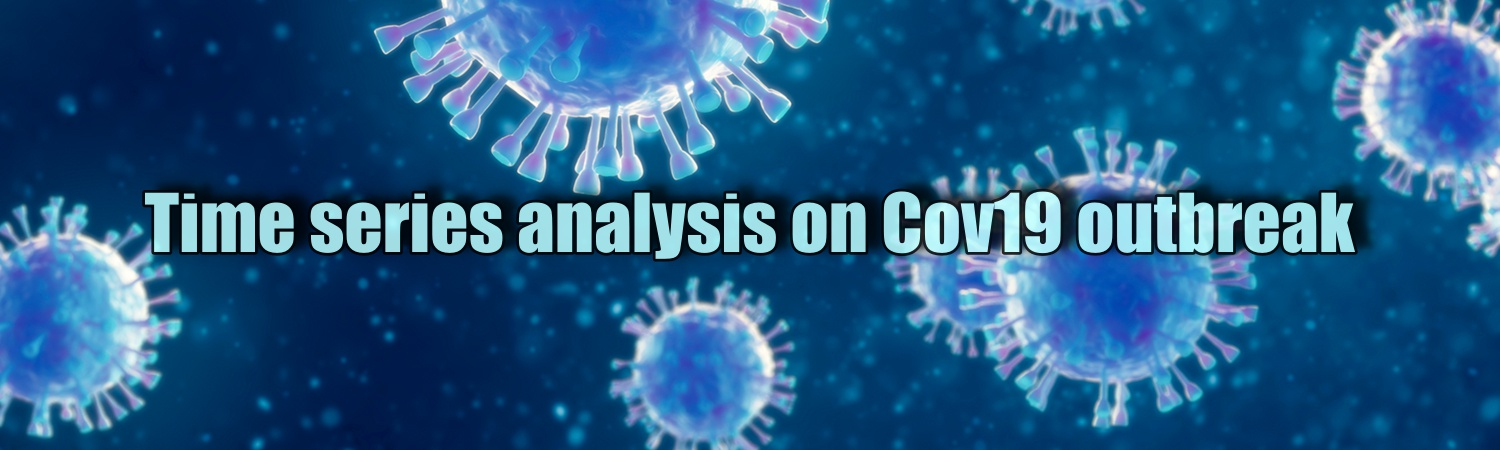

## 1.Coronavirus - Covid-19 - SARS-CoV-2

#### Coronavirus
According to the WHO, coronaviruses are a family of viruses that cause illnesses ranging from the common cold to more severe diseases such as severe acute respiratory syndrome (SARS) and the Middle East respiratory syndrome (MERS).

These viruses were originally transmitted from animals to people. SARS, for instance, was transmitted from civet cats to humans while MERS moved to humans from a type of camel.

Several known coronaviruses are circulating in animals that have not yet infected humans.

The name coronavirus comes from the Latin word corona, meaning crown or halo. Under an electron microscope, the looks like it is surrounded by a solar corona.

The novel coronavirus, identified by Chinese authorities on January 7 and since named SARS-CoV-2, is a new strain that had not been previously identified in humans. Little is known about it, although human-to-human transmission has been confirmed.   
(Source and more info on https://www.aljazeera.com/news/2020/01/coronavirus-symptoms-vaccines-risks-200122194509687.html )

![](https://www.sciencenews.org/wp-content/uploads/2020/02/021420_ac_coronainfant_feat-1028x579.jpg)

#### Prevention
This might sound repetitive, but it is very important to follow these prevention lines.
* Wash your hands frequently and carefully
* Avoid touching your face
* Stop shaking hands and hugging people
* Don’t share personal items
* Cover your mouth and nose when you cough and sneeze
* Clean and disinfect surfaces
* Take social distancing seriously
* Do not gather in groups
* Avoid eating or drinking in public places
* Wash fresh groceries
* Self-quarantine if sick  
 
Moreover, several countries have taken more strict preventions involving stricter instructions as forced confinement, please make sure to respect these lines as we should all unit to fight this pandemic.  
(source and more on https://www.healthline.com/health/coronavirus-prevention#Tips-for-prevention)  


![](https://storage.googleapis.com/proudcity/sanrafaelca/uploads/2020/03/web-banner-COVID-prevention.jpg)

## 2.Analysis introduction
This analysis goal is to visualize the daily Coronavirus data and try to further analyse the progression of the virus in different locations.  
* The first part is a quick EDA as we try to get familiar with the data and visualize it in a simpler way, then try a direct approach to see if we can deduct some forecasst from simple observation and comparison.
* The second part is the use of different time series algorithms to predict the progression of the cases of the disease. The goal in this project is to determine the best time series algorithm (between ARIMA, Prophet and LSTM) for some distibutions, I will not try to predict the future, however, feel free to use these algorithm for that purpose.  
  
This work will be mainly done through funtions so that it would be easily forked and used for different locations and cases, feel free to use this code for further dicovery.

*This analysis will be updated weekly at the time being according to the coronavirus updates, please refer to the versions if you want to check the previous versions.

# EDA

## 0.Importing libraries

#### Start with importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import itertools
import datetime 
#manipulating data and basic python libraries

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
#Preprocessing data and metrics for error evaluation

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, LSTM, ReLU
from keras.optimizers import Adam
from keras.callbacks import callbacks, EarlyStopping, ReduceLROnPlateau
#Tensorflow as our deep learning back end

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Statistical modeling using Arima

from fbprophet import Prophet
#Facebook prophet modeling

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(palette = 'Set2',style='dark',font=['simhei', 'Arial'])
#Visualization

import warnings
warnings.simplefilter('ignore')
#Ignoring warnings

#### In this analysis I will be using the dataset provided by Devakumar kp as it features daily updated data: https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv

## 1. General view of most affected countries

Import our dataset, set the time column to datetime type, rename columns for easier manipulation and modify some countries names to a more normal format.

In [ ]:
data=pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')

data['Date']=pd.to_datetime(data['Date'])
data= data.rename(columns={'Country/Region':'Country','Date':'ds','Province/State':'Province'}) 
data.replace('Korea, South','South Korea',inplace=True)
data.head()

The data has 8 columns:
* Country
* Province 
* Lat: Lattitude
* Long: Longitude
* ds: date
* Confirmed: Confirmed contaminated cases
* Deaths: Deaths provoked by the virus
* Recovered: Recovered from the virus  
  
The dataset has NaN or Null values only in the Province column as some countries don't specify.

Sum up the provinces into a bigger entity of countries

In [ ]:
df=data.groupby(['ds','Country']).agg('sum').reset_index()
df['date']=df['ds']
for i in range (0,len(df)):
    df['date'][i]=df['date'][i].strftime("%d %b")
df.tail(5)

#### Barplot of the 10 most infected countries

Plotting the most infected counrties, showing the number of confirmed cases and number of terminated cases (terminated cases here means the total of recovered and dead cases)

In [ ]:
dfCountry=df.groupby(['Country']).agg('max')
dfCountry.sort_values('Confirmed',ascending=False,inplace=True)
dfCountry=dfCountry[0:10]
dfCountry.reset_index(inplace=True)

f=plt.figure(figsize=(13,7))
ax=sns.barplot(x=dfCountry['Country'],y=dfCountry['Confirmed'], color='Orange',alpha=0.8,label='Confirmed cases')
ax=sns.barplot(x=dfCountry['Country'],y=dfCountry['Recovered']+dfCountry['Deaths'],alpha=0.8, color='purple', label='Terminated cases')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=25)
a=ax.set_title('Cases by country')

To get a clearer visualization, let's make 2 more visible graphs.

In [ ]:
dfus=df.groupby(['Country']).agg('max')
dfus.sort_values('Confirmed',ascending=False,inplace=True)
dfus.reset_index(inplace=True)
row_df = pd.DataFrame(dfus.loc[0]).T.drop(columns=['Lat','Long','ds','date'])
dfus=dfus[1:].drop(columns=['Lat','Long','ds','date']).sum(axis=0)
dfus=pd.DataFrame([dfus])
dfus = pd.concat([row_df, dfus])
dfus.reset_index(inplace=True,drop=True)
dfus.at[1, 'Country'] = 'Rest of the world'
f=plt.figure(figsize=(5,7))
ax=sns.barplot(x=dfus['Country'],y=dfus['Confirmed'], color='Orange',alpha=0.8,label='Confirmed cases')
ax=sns.barplot(x=dfus['Country'],y=dfus['Recovered']+dfus['Deaths'],alpha=0.8, color='purple', label='Terminated cases')
plt.legend()
plt.ylabel('')
a=ax.set_title('Cases by country')

In [ ]:
dfCountry=dfCountry[1:]
f=plt.figure(figsize=(13,7))
ax=sns.barplot(x=dfCountry['Country'],y=dfCountry['Confirmed'], color='Orange',alpha=0.8,label='Confirmed cases')
ax=sns.barplot(x=dfCountry['Country'],y=dfCountry['Recovered']+dfCountry['Deaths'],alpha=0.8, color='purple', label='Terminated cases')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=25)
a=ax.set_title('Cases by country')

#### World map showing the distribution and density of the confirmed contaminated cases

Projecting the data on a world map, we scaled our data with a log function as the numbers are very divergent, we also binned our numbers into 4 categories and drew them in different colors for more visibility.  
The world map is taken from internet :  https://maproom-wpengine.netdna-ssl.com/wp-content/uploads/Maproom-World-Map-2.png


In [ ]:
img=plt.imread('../input/wmappicture/WMap.png')

dfmap=df.loc[(df['ds']==df['ds'].max())]
dfmap.drop(columns=['Lat','Long'],inplace=True)
dfmap=dfa= pd.merge(dfmap, data, on=['Country','ds'], how='inner')

bins=[0,100,1000,10000,100000,1000000,100000000]
labels=['1-100','100-1000','1000-10000','10k-100k','100k-1m','1m+']
dfmap['Category']= pd.cut(dfmap["Confirmed_y"], bins , labels=labels)

f,ax=plt.subplots(figsize=(25,18))

ax.imshow(img, zorder=0,extent=( -174,188,-60, 120))
ax=plt.gca()

dfmap=dfmap.loc[dfmap['Confirmed_y']>1]
dfmap['Confirmed_y']=100*np.log(dfmap['Confirmed_y'])
dfmap.sort_values(by='Confirmed_y', inplace=True, ascending=True)

g=sns.scatterplot(y=dfmap['Lat'],x=dfmap['Long'], hue=dfmap['Category'],legend='full',s=dfmap['Confirmed_y']*2)
a=g.set(xlabel='', ylabel='', yticklabels='',xticklabels='', title='Distribution of confirmed cases around the world')
del(dfmap)

#### Plot of the time evolution of the confirmed cases of China

We use a function that can be generalized for any country and any case for further use in a simple way

In [ ]:
sns.set(palette = 'Dark2',style='darkgrid')

def pltCountry(case,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country']==a)]
        country.reset_index(inplace=True,drop=True)      
        plt.plot(country['date'],country[case],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
        ax.set(title='Evolution of the number of %s cases'%case,xlabel='Date',ylabel='Number of %s cases'%case )
        
        
pltCountry('Confirmed','China')

#### Comparing a group of countries with similar evolution: Germany, Spain, France and the US

Using the function we defined before, we compare all the cases of the 4 countries

In [ ]:
pltCountry('Confirmed', 'Germany','Spain','France','US')
pltCountry('Deaths','Germany','Spain','France','US')
pltCountry('Recovered', 'Germany','Spain','France','US')

The speed of evolution is very different from a country to another, due to precautions, equipment and other readiness to face the virus parameters, the evolution of confirmed cases in the US is the fastest, Spain and France seem like having big difficulties as the number of deaths grows faster than other countries in the same phase.

#### Comparing a group of countries with similar evolution: South Korea, Italy, Iran

In [ ]:
pltCountry('Confirmed','South Korea','Italy','Iran')
pltCountry('Deaths','South Korea','Italy','Iran')
pltCountry('Recovered','South Korea','Italy','Iran')

In these 3 countries, the pandemic started at more or less th same time, however,the graph shows a vey different evolution from a country to another, South Korea did a very good job facing the pandemic, as it could control the number of cases and keep the deaths very low, Iran and Italy were not as good in controlling the spread of the virus but the recovery process is going smoothly as the number of recovered cases is growing faster. Italy suffered most deaths.

#### Visualization the detailed evolution in a country 

Adding a column for the actual cases and displaying all the cases.

In [ ]:
df['Actual']=df['Confirmed']-(df['Deaths']+df['Recovered'])

def pltCountryDet(*argv):
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv
    cases=['Confirmed','Deaths','Recovered']
    for case in cases:
        for a in argv: 
            country=df.loc[(df['Country']==a)]
            plt.plot(country['date'],country[case],linewidth=2)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
            plt.xticks(rotation=40)
            plt.legend(cases)
            ax.set(title='Evolution in %s '%a,xlabel='Date',ylabel='Number of cases' )
            
    
pltCountryDet('Germany') 

According to this example, the first batch of recovered cases start after around 20 days of the infection.

#### Visualizing the evolution of active cases in different countries

With this feature we can see the evolution of terminated cases in different countries

In [ ]:
def actualCases(*argv):
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    
    for a in argv:
        country=df.loc[(df['Country']==a)]
        plt.plot(country['date'],country['Actual'],linewidth=2)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title=' Evolution of actual cases',xlabel='Date',ylabel='Number of cases' )


actualCases('France','Italy','Germany')

In this graph we can see that the number of confirmed cases grows in a similar way in different countries with only a shift in time, let's match the graphs in order to get a foresight from the comparison.

## 2. Comparing the evolution in different countries

By shifting time, we can compare the evolution in different countries.  
These graphs might also give us a general idea about the time it will take for some countries to control the pandemic, as we know China has now controlled the pandemic, we can use it as an example to project and compare the evolution.

#### Comparing the spread of European countries 

In [ ]:
case='Confirmed'
def timeCompare(time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country']==Coun1)]
    plt.plot(country['ds'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country']==Coun2]
    country2['ds']=country2['ds']-datetime.timedelta(days=time)
    plt.plot(country2['ds'],country2[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of cases with %d days difference '%time ,ylabel='Number of %s cases'%case )
    

timeCompare(8,'Italy','France')
timeCompare(5,'Italy','Spain')
timeCompare(7,'Italy','Germany')
timeCompare(7,'Italy','US')

# This graph shows that our intuition was right, the number are almost matching.  
In these graphs we can see that:
   * France evolution was 8 days behind Italy evolution in a slower pace, however an error in the reported numbers showed that the pandemic is actually spreadnig faster than expected in France.
   * The evolution of the numbers in Spain are only 6 days behind Italy, moreover, we can see that the derivative is a little bit higher, therefore the growth of confirmed cases is faster in Spain.
   * Germany confirmed case were also groing slightly faster than Italy's, but recently, the evolution pace has decreased.
   * In the US graph, the slope is much more noticeable and means that the spread is way faster than in European countries.    
   
   
In general, the virus in European countries is spreading in more or less the same pace.

#### Comparing the actual cases in China and Italy, the two most infected countries so far

In [ ]:
case='Actual'
timeCompare(40,'China','Italy')


In actual cases, China could control and reduce the number of sick people, the amount of sick people in Italy was growing slower than in China, but it suddenly started growing faster.  
The number of actual cases in Italy will hopefully start decreasing fast in a couple of days.   
China's numbers started droping around the 18th of February and Italy is around 41 days behind China.

The actual cases in Italy surpassed China's maximum, so it might take more time to control the pandemic in the old continent country.

Let's see the actual evolution of Italy.




#### Italy daily new confirmed and terminated cases.

In [ ]:
country=df.loc[(df['Country']=='Italy')]
f=plt.figure(figsize=(20,7))
country['Confirmed']= country['Confirmed']-country['Confirmed'].shift(1)
country['Deaths']= country['Deaths']-country['Deaths'].shift(1)
country['Recovered']= country['Recovered']-country['Recovered'].shift(1)
country['ds']=pd.to_datetime(country['ds'],format='%Y%m%d')
country=country[32:]
country.reset_index(inplace=True,drop=True)
country['date']=country['ds']
for i in range (0,len(country)):
    country['date'][i]=country['date'][i].strftime("%d %b")
country.drop(index=18,inplace=True) #The march 12th data is not provided in the dataset
ax=sns.barplot(x=country['date'],y=country['Confirmed'], color='Orange',alpha=0.8,label='Confirmed cases')
ax=sns.barplot(x=country['date'],y=country['Recovered']+country['Deaths'],alpha=0.8, color='purple', label='Terminated cases')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=-90)
plt.xlabel('')
a=ax.set_title('Evolution of daily cases in Italy per day starting on 23rd Feb (reached 100 confirmed cases)')

We can see that the number of confirmed cases is indeed getting lower in the last days as the rise of the terminated, specially recovered cases is very comforting.

In [ ]:
country=df.loc[(df['Country']=='US')]
f=plt.figure(figsize=(20,7))
country['Confirmed']= country['Confirmed']-country['Confirmed'].shift(1)
country['Deaths']= country['Deaths']-country['Deaths'].shift(1)
country['Recovered']= country['Recovered']-country['Recovered'].shift(1)
country['ds']=pd.to_datetime(country['ds'],format='%Y%m%d')
country=country[40:]
country.reset_index(inplace=True,drop=True)
country['date']=country['ds']
for i in range (0,len(country)):
    country['date'][i]=country['date'][i].strftime("%d %b")
ax=sns.barplot(x=country['date'],y=country['Confirmed'], color='Orange',alpha=0.8,label='Confirmed cases')
ax=sns.barplot(x=country['date'],y=country['Recovered']+country['Deaths'],alpha=0.8, color='purple', label='Terminated cases')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=-90)
plt.xlabel('')
a=ax.set_title('Evolution of daily cases in the US per day starting on March 2nd (reached 100 confirmed cases)')

# ARIMA

## 1.Rolling mean and standard

##### Calculating and plotting the rolling mean and standards

The rolling mean is the mean of a number of cosecutive instances (we took 4, as we have little data) , the rolling mean helps take off the anormalities in the data and draws a smoother ditribution as we can see in the plot, we will use it for our modeling.   
The rolling standard mean shows the deviation of a number of consecutive instances (we took 7 for visibility).  
We take China as an example.

In [ ]:
#sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Confirmed'):
    ts=df.loc[(df['Country']==country)]  
    ts=ts[['ds',case]]
    ts=ts.set_index('ds')
    ts.astype('int64')
    a=len(ts.loc[(ts['Confirmed']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Confirmed'):
    ts=df.loc[(df['Country']==country)]  
    ts=ts[['ds',case]]
    ts=ts.set_index('ds')
    ts.astype('int64')
    a=len(ts.loc[(ts['Confirmed']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

tsC=roll('China')
rollPlot('China')

#### Decomposing the data

The decomposition will show the trend, seasonality and residus in our data, we normally don't have seasonality in the data, so we will ignore this parameter.

In [ ]:
#Decomposing the ts to find its properties
fig=sm.tsa.seasonal_decompose(tsC.values,freq=7).plot()


## 2.Data stationarity and tranformation

#### Testing the data stationarity with the Dickey-Fuller test

Stationarity means that the statistical properties of the data doesn't change over time. The Dickey-Fuller test calculates the p-value of the data to reject the null hypothesis that the time series is non-stationary, at a 0.05 p-value, which gives us strong confidence.

In [ ]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

tsC=tsC['Confirmed'].values
stationarity(tsC)

Here the p-value helps us to reject the null hypothesis of the non-stationarity of the data with confidence, but that assumption is sometimes not enough, we should also consider the time series might not be an AR(auto-regression).   
This supposedly means that the parameter i(d) will be 0 and the model would be an ARMA model.

#### Transformation

We normally use difference to transorm our data and make it stationary, shifting and substracting the data from itself till we obtain stationarity, this process can be skipped here as we already could reject the null hypothesis with confidence.  
The integration parameter i(d) would also be determinated here as the d would be equal to number of shiftings done.

In [ ]:

#Differenciating every elemenet from the previous element to make ts stationary
#def difference(ts, times=1):
#    diff = list()
#    for i in range(times, len(ts)):
#        val = ts[i] - ts[i - times]
#        diff.append(val)
#    return pd.Series(diff)


#print('\n\nDickey fuller test after de-trend \n')
#tsCD=difference(tsC,1)
#tsCD=tsCD.values 
#plt.plot(tsCD)
#stationarity(tsCD)

## 3.Auto-correlation

#### Plotting the Auto-correlation function (ACF) and Partial auto-correlation function (PACF)

The PACF helps us determinate the AR(p) parameter.
The ACF helps us determinate the MA(q) parameter.

In [ ]:
#auto-Correlation and partial auto-correlation plots
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    
corr(tsC)

For the PACF, we notice that after 1, the values don't change much, so the parameter would supposedly be AR(p)=1.
For the ACF, there's no big change and we cannot determinate the MA(q) easily.

## 4.Modeling

#### Defining metrics, splitting data, modeling, fitting, predicting and testing.

We define the mean absolute percentage error (MAPE) as a metrics for our model, we will also use the mean absolute error.     
We split the data into 2 parts, a 85% training part and a 15% testing part.

For modeling, we take a random testing of the numbers from 0 to 6 and test them on our data to get a better accuracy, we will thus not accord much importance to the previously found parameters and rather rely on modeling to find parameters better fitting our data.

In [ ]:
#Mean absolute percentage error
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

def split(ts):
    #splitting 80%/20% because of little amount of data
    size = int(len(ts) * 0.80)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    print('\nMean absolute error: %f'%mean_absolute_error(test,pred))
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)



train,test=split(tsC)
pred=arima(train,test)


The accuracy is very good and the error is very small.  
However, we notice the model took a completely different set of parameters, this comes to confirm that the data wasn't stationary as we assumed with the p-value as the model is not Auto-correlated AR(d=0).

# Facebook Prophet

Prophet is an open-source library released by Facebook, it analyses and models the time series in a very simple and direct way.

## 1.Preprocessing

Fbprophet requires the dates column to be named 'ds' and data column to be named 'y.  
We take the US as an example here.

In [ ]:
#Taking the US example
tsU=roll('US')
rollPlot('US')

a=len(tsU.loc[(tsU['Confirmed']>=10)])
tsU=tsU[-a:]            #we omit the data in earliest stages for irrelevancy 

#renaming and preparing data for prophet
tsU.rename(columns={'Confirmed':'y'},inplace=True) #prophet requires the columns to be named ds and y
train,test= split(tsU) 

train.reset_index(inplace=True)
test.reset_index(inplace=True)

#### We fit the data and plot the components of the predicted data.

In [ ]:
#We fit the data and extract the predictions
model=Prophet(daily_seasonality=True)
model.fit(train)

pred = model.predict(test)
a=model.plot_components(pred)

#### Plotting our results, calculating the error

In [ ]:
f,ax =plt.subplots(figsize=(16,5))
plt.plot(test['ds'],test['y'],label='True values',c='red',marker='.')
plt.title('True and predicted values')
a=model.plot(pred, ax=ax)
ax.legend()

print('Mean absolute error: %d'%mean_absolute_error(test['y'],pred['yhat']))
print('Mean absolute  percentage error: %d'%mape(test['y'],pred['yhat']))

In [ ]:
#In this example, prophet didn't do a good job, we notice how the data is inconsistently growing in this #example, we migh think prophet doesn't perform well with this kind of linear distrubtion. A regression model #might be more accurate for this prediction.

## 3.Summing up the process in a function

In [ ]:
def proph(country,case='Confirmed'):
    tsU=roll(country,case)
    tsU.rename(columns={case:'y'},inplace=True) 
    tsU=tsU[30:] 
    train,test= split(tsU)

    train.reset_index(inplace=True)
    test.reset_index(inplace=True)

    model=Prophet(daily_seasonality=True)
    model.fit(train)

    pred = model.predict(test)
    f,ax =plt.subplots(figsize=(16,5))
    plt.plot(test['ds'],test['y'],label='True values',c='red',marker='.')
    plt.title('True and predicted values')
    a=model.plot(pred, ax=ax)
    ax.legend()

    print('Mean absolute error: %f'%mean_absolute_error(test['y'],pred['yhat']))
    print('Mean absolute  percentage error: %f'%mape(test['y'],pred['yhat']))
    return(pred)

# LSTM

## 1.Splitting and scaling the data

We use Sklearn MinMaxScaler for scaling, our predefined function for splitting and Italy as an example.

In [ ]:
tsI=roll('Italy')
rollPlot('Italy')
#Scale and split the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(tsI['Confirmed'].values.reshape(-1,1).astype('float32'))

train,test=split(scaled)

## 2.Transform our time series to a data frame for supervised learning


#### Creating a new dataset with look back tranformation

LSTM is a deep learning supervised learning model implementation, so we have to transform the data in order to provide a usable input and output.

In [ ]:
#Transform our ts to a usable df with lookback 
#This means we make our ts a supervised learning modelizable df
def lookBack(ts, look_back=2):
    X=list()
    Y=list()
    for i in range(len(ts) - look_back):
        a = ts[i:(i + look_back), 0]
        X.append(a)
        Y.append(ts[i + look_back, 0])
    return np.array(X), np.array(Y)

trainX, trainY = lookBack(train)
testX, testY = lookBack(test)



We set our dataset input elements to be taken from the 2 previous elements.

## 3.Modeling and fitting

#### Reshape data, create a sequential instance for our LSTM model and fitting the data

We took a 1028 LSTM layer here, and output it with a dense layer, then compiled the model with an ADAM optimizer. We trained the data in 100 epochs.

In [ ]:
#Reshape our data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#Modeling and fitting
model = Sequential()

model.add(LSTM(1028, dropout=3, input_shape=(1,2), activation='relu'))
model.add(Dense(1))

early_stop=EarlyStopping(monitor='val_loss', patience=10, verbose=0)
lr_reduce=ReduceLROnPlateau(monitor='val-loss',patience=5)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
history=model.fit(trainX,trainY, epochs = 100, batch_size = 12,validation_data=(testX, testY), 
                  shuffle=False, callbacks=[early_stop,lr_reduce])
model.summary()

#### plotting the error loss evolution to see the behavior of our model

In [ ]:
#plotting the error reduction
plt.subplots(figsize=(13,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Error reduction')
a=plt.legend()

#### Plotting the results of ou model and comparing it to the actual data

In [ ]:
#plotting our resutls and the error of our scaled data
pred=model.predict(testX)
f,ax=plt.subplots(figsize=(13,5))
plt.plot(pred, label='Predict')
plt.plot(testY, label='True')
plt.legend()
plt.title('Predicted vs true scaled values')

print('Mean absolute error: %f'%mean_absolute_error(testY,pred))
print('Mean absolute  percentage error: %f'%mape(testY,pred))

## 4.Inverse calculating the results

#### Reversing the scaling, extracting dates and shaping the results before plotting them

In [ ]:
#reversing the scaling
predictions= scaler.inverse_transform(pred.reshape(-1, 1))
test_val = scaler.inverse_transform(testY.reshape(-1, 1))
#getting the dates back
dates = tsI.tail(len(testX)).index
#reshaping
predictions = predictions.reshape(len(predictions))
test_val = test_val.reshape(len(test_val))

#plotting the data
f, ax=plt.subplots(figsize=(16,5))
plt.plot(tsI)
plt.plot(dates, test_val, label= 'True', c='red',marker='.')
plt.plot(dates, predictions, label= 'Predicted', marker='.' ,c='purple')
plt.xticks([])
plt.title('True vs predicted values')
a=plt.legend()
print('Mean absolute error: %f'%mean_absolute_error(test_val,predictions))
print('Mean absolute  percentage error: %f'%mape(test_val,predictions))

## 5.Summing up the LSTM process in a function

In [ ]:
def lstm(country,case='Confirmed'):
    ts=roll(country,case)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(ts[case].values.reshape(-1,1).astype('float32'))

    train,test=split(scaled)

    trainX, trainY = lookBack(train)
    testX, testY = lookBack(test)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    model = Sequential()

    model.add(LSTM(1028, dropout=3, input_shape=(1,2), activation='relu'))
    model.add(Dense(1))

    early_stop=EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    lr_reduce=ReduceLROnPlateau(monitor='val-loss',patience=5)
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
    history=model.fit(trainX,trainY, epochs = 100, batch_size = 12,validation_data=(testX, testY), 
                      shuffle=False, callbacks=[early_stop,lr_reduce])
    
    pred=model.predict(testX)
    
    predictions= scaler.inverse_transform(pred.reshape(-1, 1))
    test_val = scaler.inverse_transform(testY.reshape(-1, 1))

    dates = ts.tail(len(testX)).index

    predictions = predictions.reshape(len(predictions))
    test_val = test_val.reshape(len(test_val))

    f, ax=plt.subplots(figsize=(16,5))
    plt.plot(ts)
    plt.plot(dates, test_val, label= 'True', c='red',marker='.')
    plt.plot(dates, predictions, label= 'Predicted', marker='.' ,c='purple')
    plt.xticks([])
    plt.title('True vs predicted values')
    a=plt.legend()
    print('Mean absolute error: %f'%mean_absolute_error(test_val,predictions))
    print('Mean absolute  percentage error: %f'%mape(test_val,predictions))
    return predictions


# Models comparison on same data

Let's now do a model comparison on the same time series data, we apply the 3 models and compare the results.  
We take the Germany data.

In [ ]:
rollPlot('Germany')

## 1.ARIMA on Germany data

In [ ]:
ts=roll('Germany')
ts=ts['Confirmed'].values
train,test=split(ts)
a=arima(train,test)

## 2.Prophet on Germany data

In [ ]:
a=proph('Germany')

## 3.LSTM on Germany data

In [ ]:
a=lstm('Germany')